In [29]:
from typing import Dict, Tuple, List, Optional, Union, Any
from pathlib import Path
import numpy as np # type: ignore
import awkward as ak # type: ignore
import uproot # type: ignore
import yaml # type: ignore
import os
import random
import shutil
import logging
import json
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
from pathlib import Path
import h5py # type: ignore

from l1deepmet.plotting import control_plots
from l1deepmet.utils import to_np_array

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)


In [30]:
def HCalDepth(
    hcal_first1: np.ndarray, hcal_first3: np.ndarray, hcal_first5: np.ndarray
) -> np.ndarray:
    """Effective center of energy depth in the hadronic calorimeter of Phase-2 HGCal.

    Mirrors convertNanoToHDF5.HCalDepth with numerically safe handling of zeros.
    """
    epsilon = 1.0e-10
    hcal_first5_safe = np.where(hcal_first5 == 0, epsilon, hcal_first5)
    depth_weighted = (
        hcal_first1 * 1.0
        + (hcal_first3 - hcal_first1) * 3.0
        + (hcal_first5 - hcal_first3) * 5.0
    ) / hcal_first5_safe
    depth_weighted = np.where(hcal_first5 == 0, 0.0, depth_weighted)
    return depth_weighted

In [31]:
def load_samples_to_numpy(
    data_root: Union[str, Path],
    sample_names: List[str],
    var_list: List[str],
    var_list_mc: Optional[List[str]] = None,
    *,
    max_pf: int,
    encoding: Dict[str, Dict[float, int]],
    include_mc: bool = True,
    step_size: str = "100 MB",
    file_pattern: str = "*.root",
    tree_name: str = "Events",
    dtype=np.float32,
) -> Dict[str, Tuple[np.ndarray, np.ndarray]]: 
    """
    returns a tuple of numpy arrays (features, targets) over all samples
    """

    data_root = Path(data_root)
    results: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}

    logger.info(f"Starting data loading from {data_root}")
    logger.info(f"Processing {len(sample_names)} samples: {sample_names}")

    for i, sample in enumerate(sample_names, 1):
        logger.info(f"[{i}/{len(sample_names)}] Processing sample: {sample}")
        
        files = sorted((data_root / sample).rglob(file_pattern))
        if not files:
            raise FileNotFoundError(f"No ROOT files found for sample '{sample}' under {data_root / sample}")

        logger.info(f"  Found {len(files)} ROOT files")
        
        branches = list(var_list)
        if include_mc and var_list_mc:
            branches += var_list_mc
        logger.info(f"  Loading {len(branches)} branches from tree '{tree_name}'")
        logger.debug(f"  Branches: {branches}")
        
        X_parts: List[np.ndarray] = []
        Y_parts: List[np.ndarray] = []

        # Specify the tree name by appending to file paths
        files_with_tree = [str(f) + f":{tree_name}" for f in files]
        
        logger.info(f"  Starting iteration over files with step_size={step_size}")
        batch_count = 0
        
        for arrays in uproot.iterate(files_with_tree, expressions=branches, step_size=step_size, library="ak"):
            batch_count += 1
            logger.info(f"  Processing batch {batch_count}...")
            # Per-candidate inputs (awkward jagged -> dense with padding)
            pt = to_np_array(arrays["L1PuppiCands_pt"], maxN=max_pf, pad=0.0)
            eta = to_np_array(arrays["L1PuppiCands_eta"], maxN=max_pf, pad=0.0)
            phi = to_np_array(arrays["L1PuppiCands_phi"], maxN=max_pf, pad=0.0)
            pdgid = to_np_array(arrays["L1PuppiCands_pdgId"], maxN=max_pf, pad=-999.0)
            charge = to_np_array(arrays["L1PuppiCands_charge"], maxN=max_pf, pad=-999.0)
            puppiw = to_np_array(arrays["L1PuppiCands_puppiWeight"], maxN=max_pf, pad=0.0)
            dxyErr = to_np_array(arrays["L1PuppiCands_dxyErr"], maxN=max_pf, pad=1000.0)

            h1 = to_np_array(arrays["HGCal3DCl_firstHcal1layers"], maxN=max_pf, pad=0.0)
            h3 = to_np_array(arrays["HGCal3DCl_firstHcal3layers"], maxN=max_pf, pad=0.0)
            h5 = to_np_array(arrays["HGCal3DCl_firstHcal5layers"], maxN=max_pf, pad=0.0)
            hcalDepth = HCalDepth(h1, h3, h5)

            px = pt * np.cos(phi)
            py = pt * np.sin(phi)

            enc_pdg = np.vectorize(encoding["L1PuppiCands_pdgId"].__getitem__)(pdgid.astype(float))
            enc_chg = np.vectorize(encoding["L1PuppiCands_charge"].__getitem__)(charge.astype(float))

            nevents = pt.shape[0]
            X = np.zeros((nevents, max_pf, 10), dtype=dtype, order="F")
            X[:, :, 0] = pt
            X[:, :, 1] = px
            X[:, :, 2] = py
            X[:, :, 3] = eta
            X[:, :, 4] = phi
            X[:, :, 5] = puppiw
            X[:, :, 6] = enc_pdg
            X[:, :, 7] = enc_chg
            X[:, :, 8] = hcalDepth

            if include_mc and var_list_mc:
                gen_pt = arrays["genMet_pt"].to_numpy()
                gen_phi = arrays["genMet_phi"].to_numpy()
                Y = np.stack([gen_pt * np.cos(gen_phi), gen_pt * np.sin(gen_phi)], axis=1).astype(dtype, copy=False)
            else:
                Y = np.zeros((nevents, 2), dtype=dtype)

            X_parts.append(X)
            Y_parts.append(Y)
            logger.info(f"Batch {batch_count} complete: {nevents} events processed")
        
        # TODO: don't hardcode the number of features
        features = np.concatenate(X_parts, axis=0) if X_parts else np.zeros((0, max_pf, 9), dtype=dtype)
        targets = np.concatenate(Y_parts, axis=0) if Y_parts else np.zeros((0, 2), dtype=dtype)
        results[sample] = (features, targets)
        
        logger.info(f"Sample '{sample}' complete: {features.shape[0]} total events, shape {features.shape}")

    logger.info(f"Data loading complete. Processed {len(results)} samples")
    return results

In [32]:
# load config from yaml 
config_path = Path("/home/users/dprimosc/L1DeepMET/notebooks/preprocess_config.yaml")
with open(config_path, "r") as f:
    cfg = yaml.safe_load(f)

data_cfg = cfg["data"]

# Parse sample list with event counts
sample_list_raw = data_cfg["sample-list"]
samples = {}
for item in sample_list_raw:
    for sample_name, n_events in item.items():
        samples[sample_name] = n_events

logger.info(f"Sample configuration: {samples}")

sample_names = list(samples.keys())
var_list = data_cfg["var-list"]
var_list_mc = data_cfg.get("var-list-mc", [])
max_pf = int(data_cfg["max-n-PUPPI-Cands"])
encoding_raw = data_cfg["discrete-encoding"]

# Coerce YAML keys to numeric for robust mapping
def _coerce_encoding(enc):
    return {k: {float(kk): int(vv) for kk, vv in v.items()} for k, v in enc.items()}

encoding = _coerce_encoding(encoding_raw)

# TODO: this should be based on CL arg in the script
data_root = Path("/home/users/dprimosc/L1DeepMET/data/25Jul8_140X_v0")
include_mc = len(var_list_mc) > 0

results = load_samples_to_numpy(
    data_root=data_root,
    sample_names=sample_names,
    var_list=var_list,
    var_list_mc=var_list_mc,
    max_pf=max_pf,
    encoding=encoding,
    include_mc=include_mc,
    step_size="100 MB", 
    dtype=np.float32,
)

20:15:02 - INFO - Sample configuration: {'TT_PU200': 100000, 'VBFHToInvisible_PU200': 48000}
20:15:02 - INFO - Starting data loading from /home/users/dprimosc/L1DeepMET/data/25Jul8_140X_v0
20:15:02 - INFO - Processing 2 samples: ['TT_PU200', 'VBFHToInvisible_PU200']
20:15:02 - INFO - [1/2] Processing sample: TT_PU200
20:15:02 - INFO -   Found 25 ROOT files
20:15:02 - INFO -   Loading 16 branches from tree 'Events'
20:15:02 - INFO -   Starting iteration over files with step_size=100 MB
20:15:04 - INFO -   Processing batch 1...
20:15:04 - INFO - Batch 1 complete: 9000 events processed
20:15:05 - INFO -   Processing batch 2...
20:15:06 - INFO - Batch 2 complete: 14000 events processed
20:15:08 - INFO -   Processing batch 3...
20:15:09 - INFO - Batch 3 complete: 14000 events processed
20:15:10 - INFO -   Processing batch 4...
20:15:11 - INFO - Batch 4 complete: 14000 events processed
20:15:12 - INFO -   Processing batch 5...
20:15:13 - INFO - Batch 5 complete: 14000 events processed
20:15:

In [33]:
def select_events(results, samples):
    # Select desired number of events per sample
    logger.info("Selecting desired number of events per sample")

    selected_results = {}
    for sample_name, (features, targets) in results.items():
        n_desired = samples[sample_name]
        n_available = features.shape[0]
        
        if n_available >= n_desired:
            # Randomly select n_desired events
            indices = np.random.choice(n_available, size=n_desired, replace=False)
            selected_features = features[indices]
            selected_targets = targets[indices]
            logger.info(f"{sample_name}: Selected {n_desired} events from {n_available} available")
        else:
            # Use all available events if we don't have enough
            selected_features = features
            selected_targets = targets
            logger.warning(f"{sample_name}: Only {n_available} events available, requested {n_desired}")
        
        selected_results[sample_name] = (selected_features, selected_targets)
        print(f"{sample_name}")
        print(selected_features.shape)
    return selected_results
selected_results = select_events(results, samples)


20:16:07 - INFO - Selecting desired number of events per sample
20:16:08 - INFO - TT_PU200: Selected 100000 events from 299000 available


TT_PU200
(100000, 128, 10)


20:16:08 - INFO - VBFHToInvisible_PU200: Selected 48000 events from 48000 available


VBFHToInvisible_PU200
(48000, 128, 10)


In [34]:
# run all preprocessing steps
for key, value in results.items():
    print(key)
    print(results[key][0].shape)

def preprocess_data(selected_results):
    """
    Apply preprocessing steps to the selected data, based on preprocessing.py::preProcessing
    but without normalization factor. Returns single concatenated feature array.
    
    Steps:
    - Extract pt, px, py, eta, phi, puppi, dxyErr, hcalDepth
    - Remove outliers in pt/px/py and sanitize dxyErr/hcalDepth
    - Concatenate into single feature array for H5 storage
    
    Feature array layout (9 features):
    [:, :, 0] = pt, [:, :, 1] = eta, [:, :, 2] = phi, [:, :, 3] = puppi,
    [:, :, 4] = hcal_depth, [:, :, 5] = px, [:, :, 6] = py,
    [:, :, 7] = encoded_pdgId, [:, :, 8] = encoded_charge
    
    Returns:
    - processed_results: dict with sample_name -> (preprocessed_features, targets)
    """
    logger.info("Applying preprocessing steps to selected data")
    
    processed_results = {}
    
    for sample_name, (features, targets) in selected_results.items():
        logger.info(f"Preprocessing sample: {sample_name}")
        
        A = features  
        
        pt = A[:, :, 0:1]          
        px = A[:, :, 1:2]          
        py = A[:, :, 2:3]          
        eta = A[:, :, 3:4]         
        phi = A[:, :, 4:5]         
        puppi = A[:, :, 5:6]       
        dxyErr = A[:, :, 8:9]      
        hcalDepth = A[:, :, 9:10]  
        
        # Remove outliers in momentum (using 500 GeV cutoff, no normalization)
        pt[np.where(np.abs(pt) > 500.0)] = 0.0
        px[np.where(np.abs(px) > 500.0)] = 0.0  
        py[np.where(np.abs(py) > 500.0)] = 0.0
        
        # Sanitize dxyErr and hcalDepth
        dxyErr[np.where(dxyErr == -999)] = 0.0
        dxyErr[np.where(np.abs(dxyErr) > 100.0)] = 0.0
        hcalDepth[np.where(~np.isfinite(hcalDepth))] = 0.0
        hcalDepth[np.where(np.abs(hcalDepth) > 100.0)] = 0.0
        
        # Create single preprocessed feature array (gets split later in training)
        # Layout: [pt, eta, phi, puppi, hcal_depth, px, py, encoded_pdgId, encoded_charge]
        inputs_cat0_expanded = A[:, :, 6:7]  # encoded pdgId 
        inputs_cat1_expanded = A[:, :, 7:8]  # encoded charge 
        
        preprocessed_features = np.concatenate([
            pt,                    # [:, :, 0] 
            eta,                   # [:, :, 1]
            phi,                   # [:, :, 2] 
            puppi,                 # [:, :, 3]
            hcalDepth,             # [:, :, 4]
            px,                    # [:, :, 5]
            py,                    # [:, :, 6]
            inputs_cat0_expanded,  # [:, :, 7] 
            inputs_cat1_expanded   # [:, :, 8]
        ], axis=2)
        
        processed_results[sample_name] = (preprocessed_features, targets)
        
        logger.info(f"  {sample_name} processed shapes:")
        logger.info(f"    features: {preprocessed_features.shape} (all preprocessed features)")
        logger.info(f"    targets: {targets.shape}")
    
    logger.info("Preprocessing complete")
    return processed_results

processed_results = preprocess_data(selected_results)


20:16:08 - INFO - Applying preprocessing steps to selected data
20:16:08 - INFO - Preprocessing sample: TT_PU200


TT_PU200
(299000, 128, 10)
VBFHToInvisible_PU200
(48000, 128, 10)


20:16:09 - INFO -   TT_PU200 processed shapes:
20:16:09 - INFO -     features: (100000, 128, 9) (all preprocessed features)
20:16:09 - INFO -     targets: (100000, 2)
20:16:09 - INFO - Preprocessing sample: VBFHToInvisible_PU200
20:16:09 - INFO -   VBFHToInvisible_PU200 processed shapes:
20:16:09 - INFO -     features: (48000, 128, 9) (all preprocessed features)
20:16:09 - INFO -     targets: (48000, 2)
20:16:09 - INFO - Preprocessing complete


In [35]:
def combine_shuffle_split(selected_results, data_cfg):
    # Combine samples and create train/val/test splits
    logger.info("Combining samples and creating train/val/test splits")

    # Combine all samples
    all_features = []
    all_targets = []
    for sample_name, (features, targets) in processed_results.items():
        logger.info(f"Adding {sample_name}: {features.shape[0]} events")
        all_features.append(features)
        all_targets.append(targets)

    # Concatenate and shuffle
    X_combined = np.concatenate(all_features, axis=0)
    Y_combined = np.concatenate(all_targets, axis=0)
    logger.info(f"Combined dataset: {X_combined.shape[0]} total events")

    # Shuffle indices
    np.random.seed(42)  # For reproducibility
    indices = np.arange(len(X_combined))
    np.random.shuffle(indices)
    X_combined = X_combined[indices]
    Y_combined = Y_combined[indices]

    # Get split ratios from config
    split_config = data_cfg["train-val-test-split"]
    train_ratio = split_config["train"]
    val_ratio = split_config["val"]
    test_ratio = split_config["test"]

    # Calculate split indices
    train_split = int(train_ratio * len(X_combined))
    val_split = int((train_ratio + val_ratio) * len(X_combined))

    # Create splits
    X_train, Y_train = X_combined[:train_split], Y_combined[:train_split]
    X_val, Y_val = X_combined[train_split:val_split], Y_combined[train_split:val_split]
    X_test, Y_test = X_combined[val_split:], Y_combined[val_split:]

    logger.info(f"Train split: {X_train.shape[0]} events ({train_ratio:.1%})")
    logger.info(f"Val split: {X_val.shape[0]} events ({val_ratio:.1%})")
    logger.info(f"Test split: {X_test.shape[0]} events ({test_ratio:.1%})")

    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Test data shape: {X_test.shape}")
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

X_train, X_val, X_test, Y_train, Y_val, Y_test = combine_shuffle_split(processed_results, data_cfg)


20:16:09 - INFO - Combining samples and creating train/val/test splits
20:16:09 - INFO - Adding TT_PU200: 100000 events
20:16:09 - INFO - Adding VBFHToInvisible_PU200: 48000 events
20:16:09 - INFO - Combined dataset: 148000 total events
20:16:09 - INFO - Train split: 118400 events (80.0%)
20:16:09 - INFO - Val split: 14800 events (10.0%)
20:16:09 - INFO - Test split: 14800 events (10.0%)


Training data shape: (118400, 128, 9)
Validation data shape: (14800, 128, 9)
Test data shape: (14800, 128, 9)


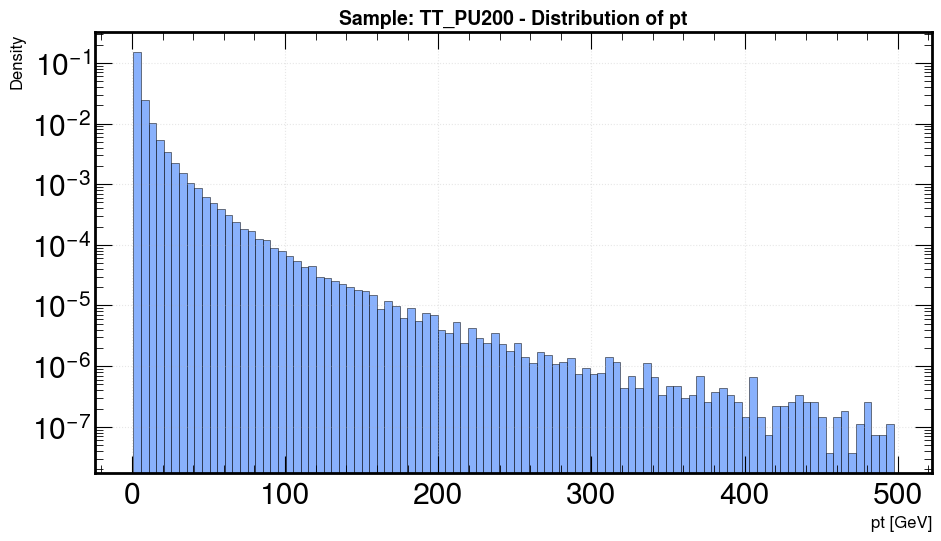

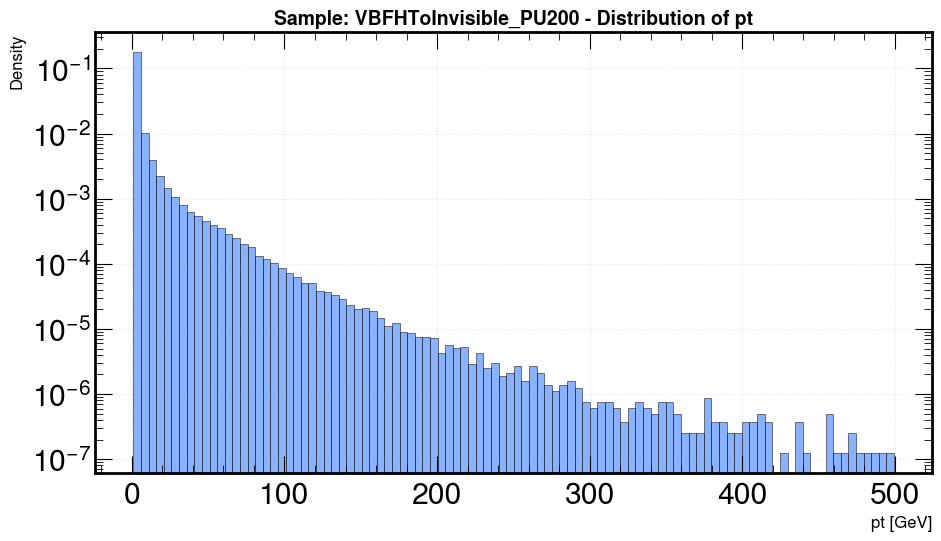

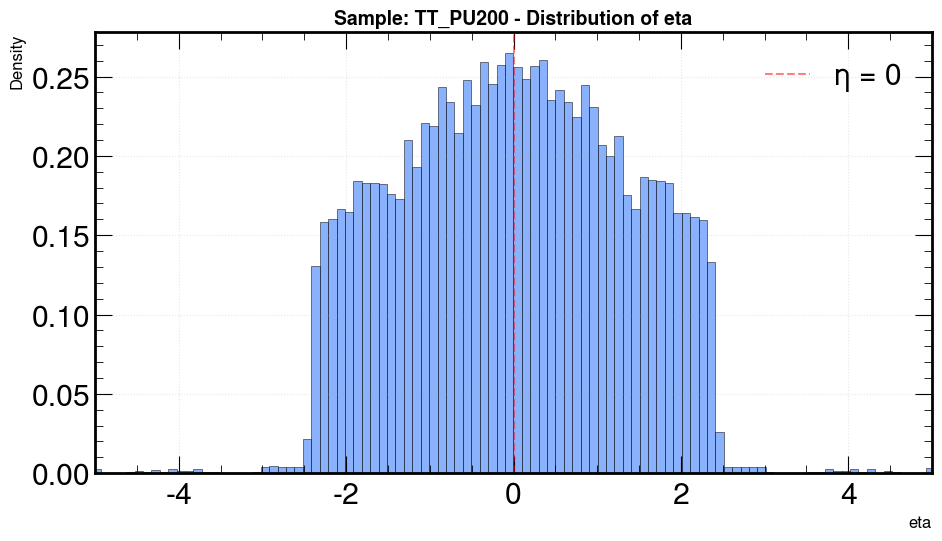

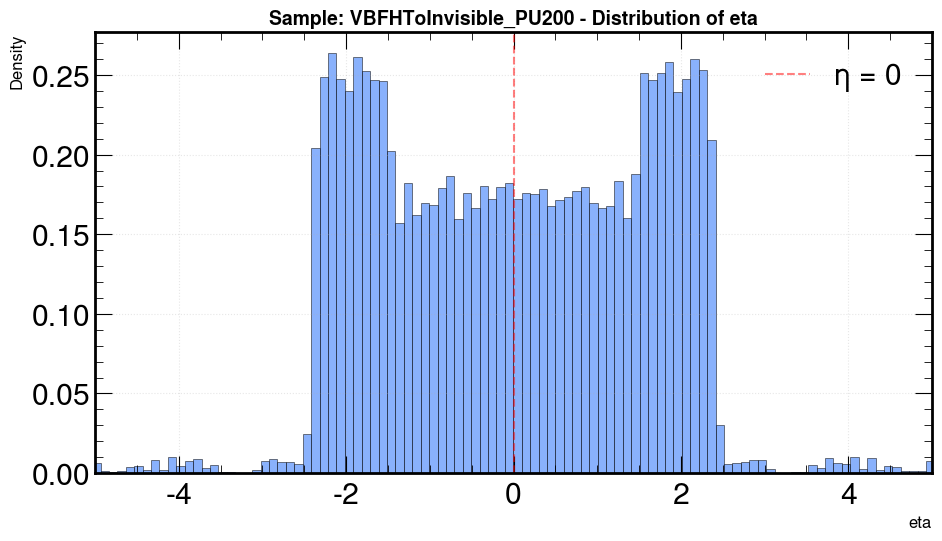

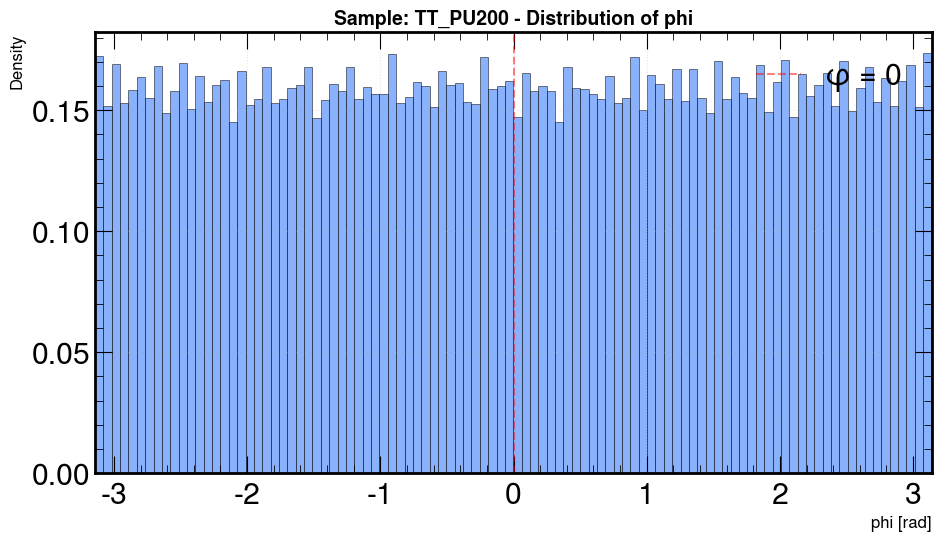

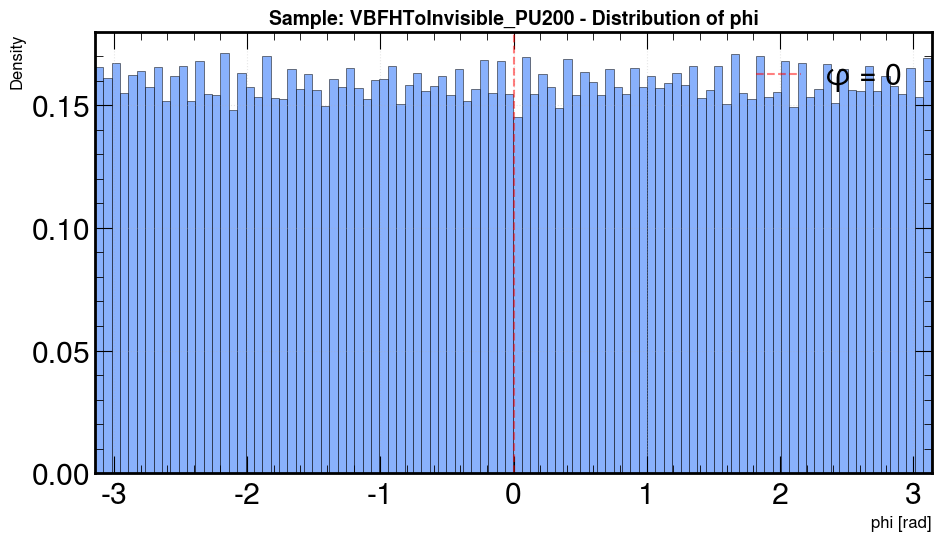

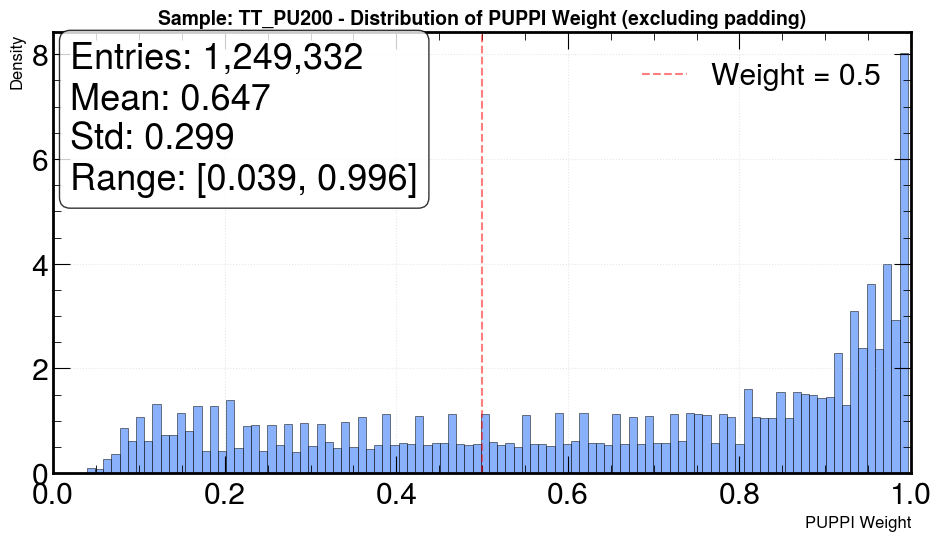

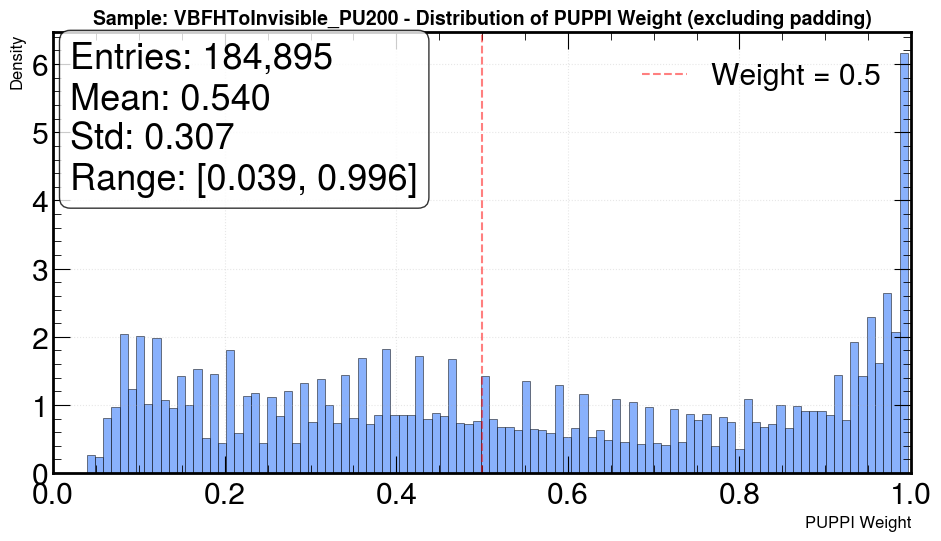

/home/users/dprimosc/micromamba/envs/l1deepmet/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


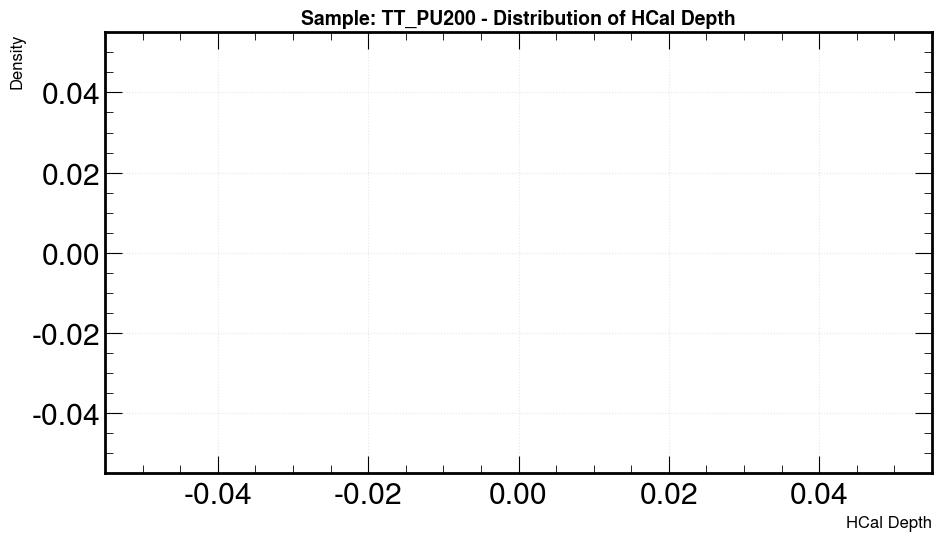

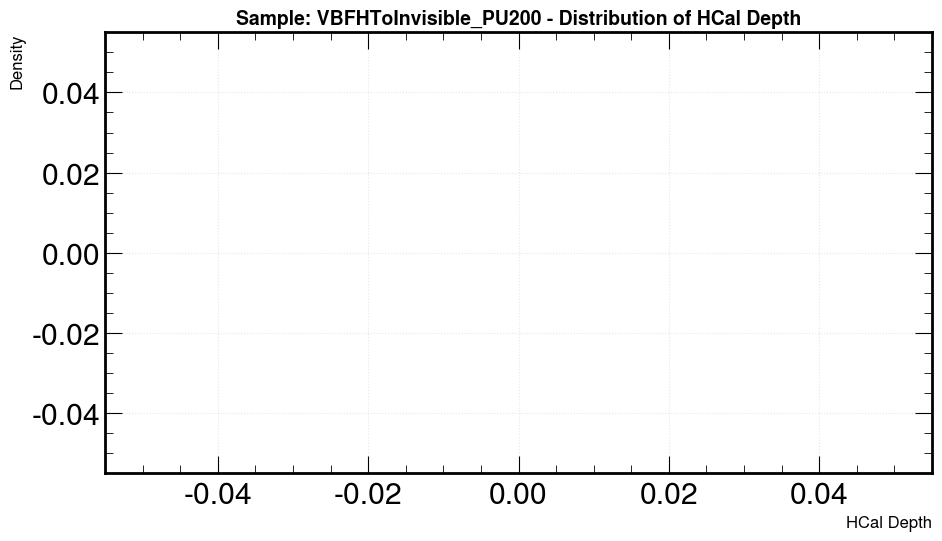

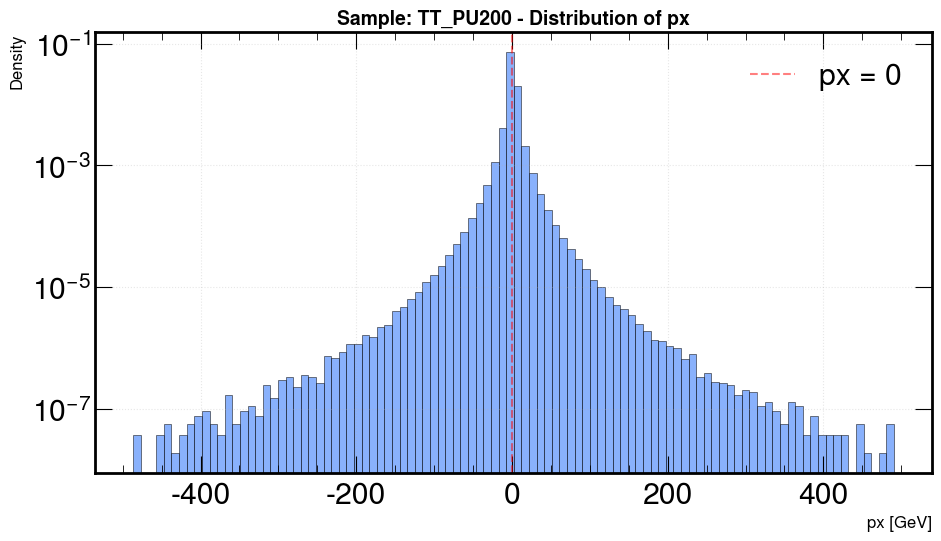

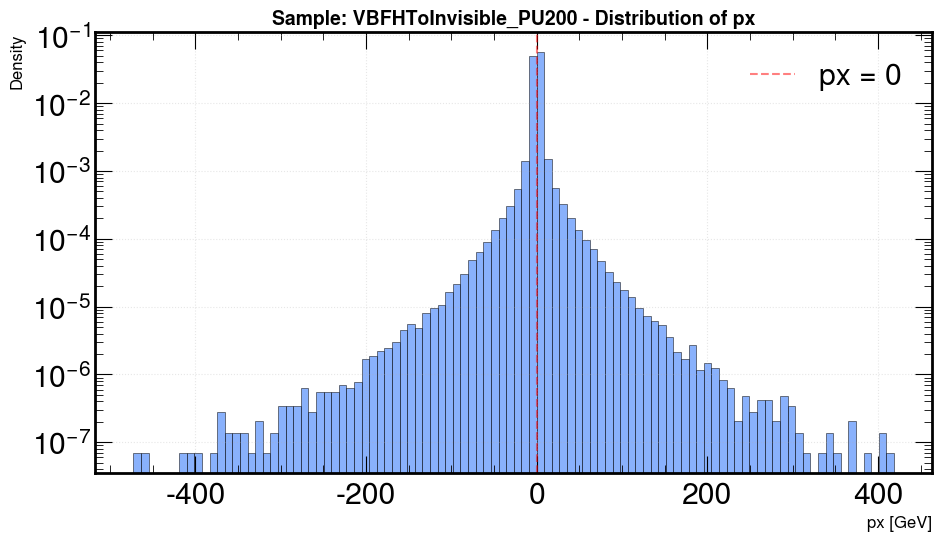

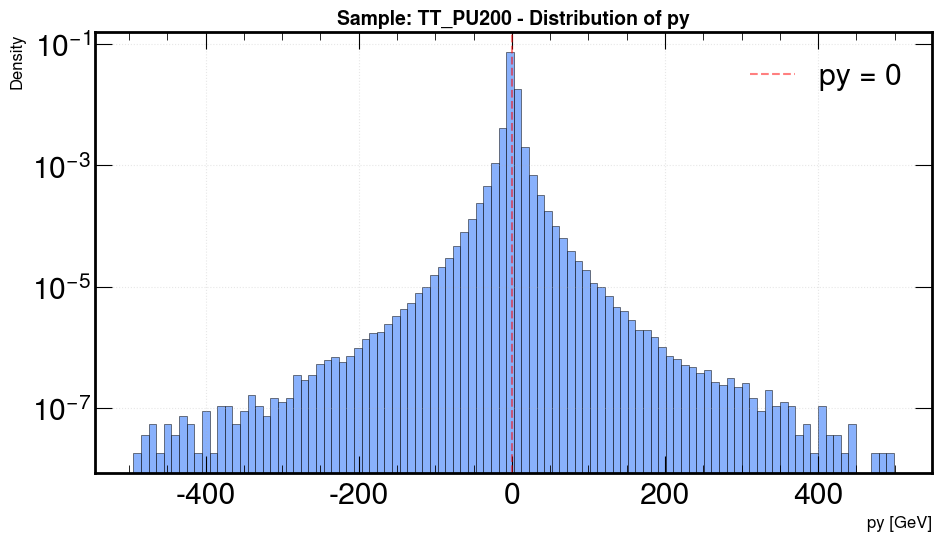

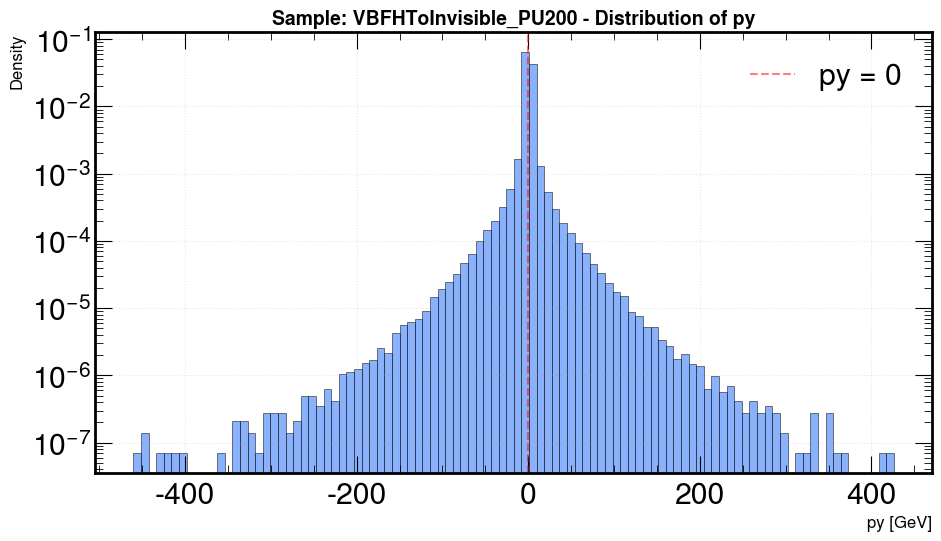

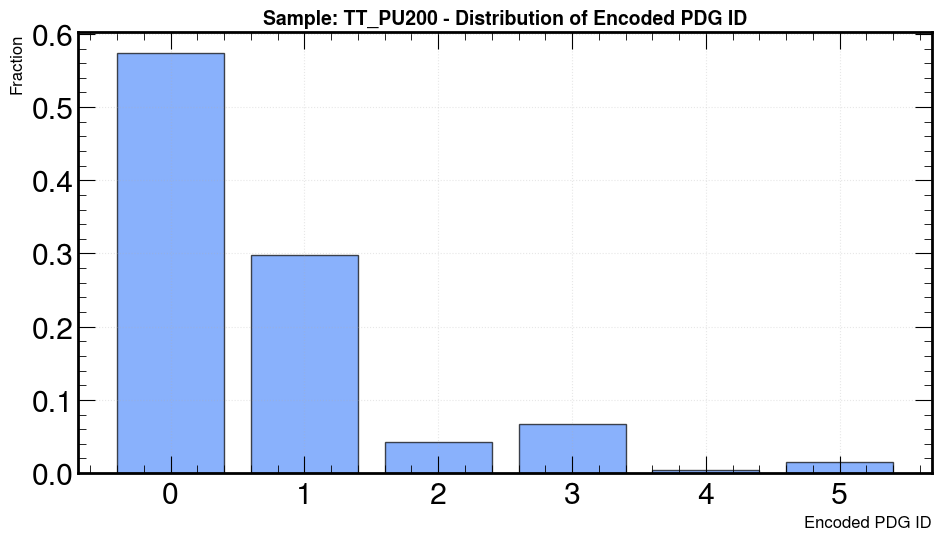

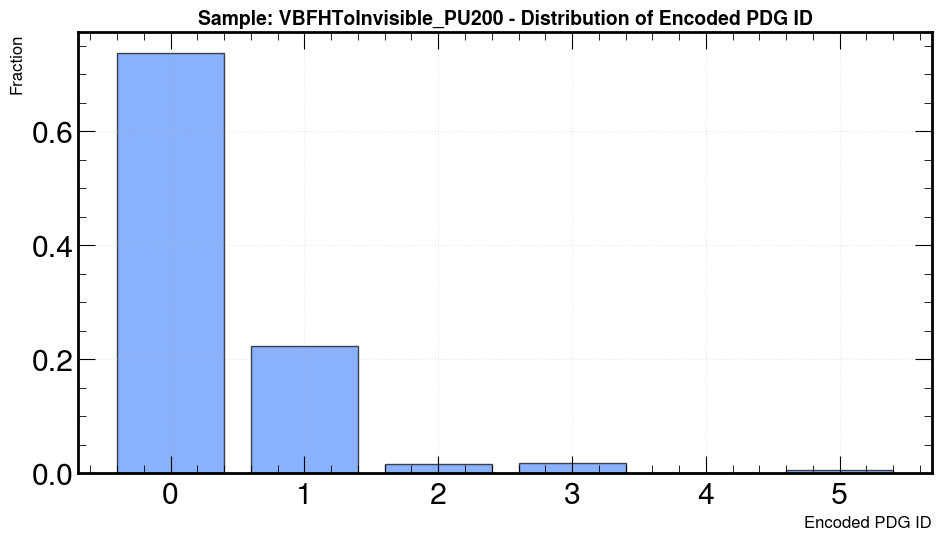

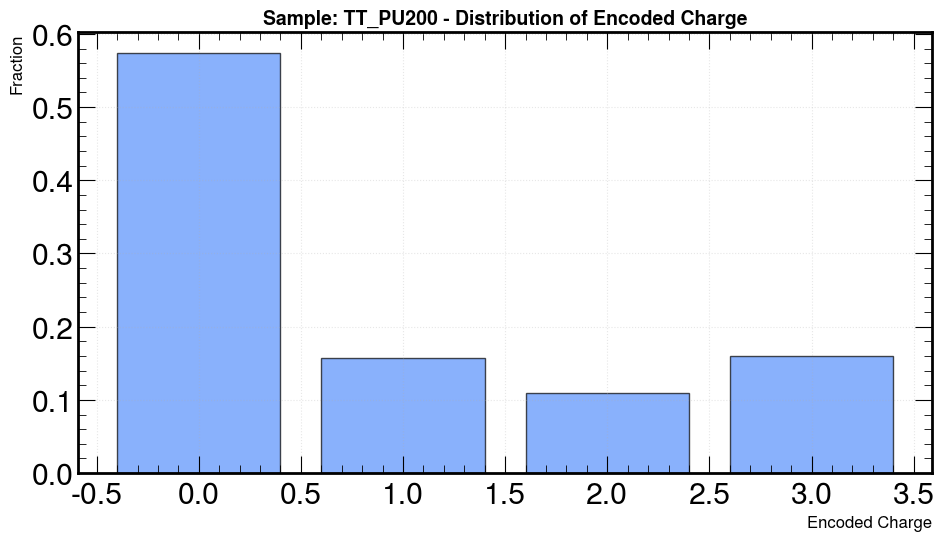

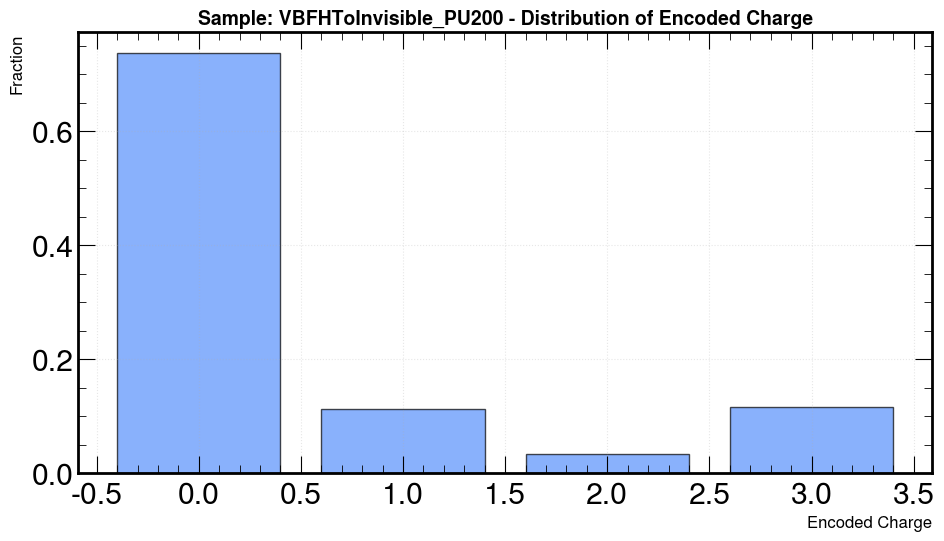

In [36]:
from l1deepmet.plotting import control_plots

control_plots(processed_results, plot_dir)

In [39]:


tag = "25Jul8_140X_v0"
output_dir = Path(f"/home/users/dprimosc/L1DeepMET/data/preprocessed/{tag}")
output_dir.mkdir(exist_ok=True)

logger.info(f"Saving preprocessed data in {output_dir}")

# Metadata to save in each file
metadata = {
    'feature_layout': ['pt', 'eta', 'phi', 'puppi_weight', 'hcal_depth', 
                      'px', 'py', 'encoded_pdgId', 'encoded_charge'],
    'n_features': X_train.shape[2],
    'max_puppi_candidates': X_train.shape[1],
    'samples_used': list(samples.keys()),
    'sample_event_counts': list(samples.values())
}

train_file_path = output_dir / "train.h5"
with h5py.File(train_file_path, 'w') as f:
    f.create_dataset('features', data=X_train, compression='gzip', compression_opts=9)
    f.create_dataset('targets', data=Y_train, compression='gzip', compression_opts=9)
    
    
    for key, value in metadata.items():
        f.attrs[key] = value

logger.info(f"Training data saved to {train_file_path}")
logger.info(f"  Shape: features {X_train.shape}, targets {Y_train.shape}")
logger.info(f"  File size: {train_file_path.stat().st_size / 1024**2:.1f} MB")


val_file_path = output_dir / "val.h5"
with h5py.File(val_file_path, 'w') as f:
    f.create_dataset('features', data=X_val, compression='gzip', compression_opts=9)
    f.create_dataset('targets', data=Y_val, compression='gzip', compression_opts=9)
    
    for key, value in metadata.items():
        f.attrs[key] = value

logger.info(f"Validation data saved to {val_file_path}")
logger.info(f"  Shape: features {X_val.shape}, targets {Y_val.shape}")
logger.info(f"  File size: {val_file_path.stat().st_size / 1024**2:.1f} MB")


test_file_path = output_dir / "test.h5"
with h5py.File(test_file_path, 'w') as f:
    f.create_dataset('features', data=X_test, compression='gzip', compression_opts=9)
    f.create_dataset('targets', data=Y_test, compression='gzip', compression_opts=9)
    

    for key, value in metadata.items():
        f.attrs[key] = value

logger.info(f"Test data saved to {test_file_path}")
logger.info(f"  Shape: features {X_test.shape}, targets {Y_test.shape}")
logger.info(f"  File size: {test_file_path.stat().st_size / 1024**2:.1f} MB")


total_size = (train_file_path.stat().st_size + val_file_path.stat().st_size + 
              test_file_path.stat().st_size) / 1024**2
logger.info(f"All H5 files saved successfully to {output_dir}")



20:22:13 - INFO - Saving preprocessed data in /home/users/dprimosc/L1DeepMET/data/preprocessed/25Jul8_140X_v0
20:23:50 - INFO - Training data saved to /home/users/dprimosc/L1DeepMET/data/preprocessed/25Jul8_140X_v0/train.h5
20:23:50 - INFO -   Shape: features (118400, 128, 9), targets (118400, 2)
20:23:50 - INFO -   File size: 74.6 MB
20:24:03 - INFO - Validation data saved to /home/users/dprimosc/L1DeepMET/data/preprocessed/25Jul8_140X_v0/val.h5
20:24:03 - INFO -   Shape: features (14800, 128, 9), targets (14800, 2)
20:24:03 - INFO -   File size: 11.1 MB
20:24:16 - INFO - Test data saved to /home/users/dprimosc/L1DeepMET/data/preprocessed/25Jul8_140X_v0/test.h5
20:24:16 - INFO -   Shape: features (14800, 128, 9), targets (14800, 2)
20:24:16 - INFO -   File size: 11.0 MB
20:24:16 - INFO - All H5 files saved successfully to /home/users/dprimosc/L1DeepMET/data/preprocessed/25Jul8_140X_v0
